In [1]:
from os import listdir
from os import path
from random import sample
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def loadDat(filename):
  fh = open(filename)
  dat = pd.read_csv(fh)
  fh.close()
  return dat

In [2]:
year = 2022
datadir = path.join('.', str(year))
files = listdir(datadir)
files

['proj_rb22.csv',
 'proj_wr22.csv',
 'proj_qb22.csv',
 'proj_te22.csv',
 'proj_k22.csv']

In [3]:
# need to exclude "current" data
files = [i for i in files if 'proj' in i]
patt = r'proj_(.*)' + str(year)[2:4] + '.csv'
pos = [re.sub(patt, r'\1', f) for f in files]
dat = {}
cols = set()
for p in pos:
  dat[p] = loadDat(path.join(datadir, files[pos.index(p)]))
  cols.update(set(dat[p].columns))
for p in pos:
  nr = len(dat[p].index)
  nodat = [0 for i in range(nr)]
  for i in cols.difference(set(dat[p].columns)):
    dat[p][i] = nodat
  dat[p] = dat[p][list(cols)]
  dat[p]['pos'] = [p for i in range(nr)]
col1 = ['PlayerName','Team','pos','fpts']
colo = col1 + list(cols.difference(col1))
m = pd.concat(dat)[colo]
m['p_fg'] = m['fg'] * 4
m['p_xpt'] = m['xpt'] * 1
m['p_pass_yds'] = m['pass_yds'] / 25
m['p_pass_tds'] = m['pass_tds'] * 4
m['p_pass_ints'] = m['pass_ints'] * -2
m['p_rush_yds'] = m['rush_yds'] / 10
m['p_rush_tds'] = m['rush_tds'] * 6
m['p_fumbles'] = m['fumbles'] * -2
m['p_rec_yds'] = m['rec_yds'] / 20
m['p_rec_tds'] = m['rec_tds'] * 6
m['points'] = m.filter(regex = ("p_.*")).sum(axis = 1)
m = m.sort_values(by=['points'], ascending = False)
basePnt = {}
basePnt['k'] = m.loc[('k'),'points'].iloc[11]
basePnt['qb'] = m.loc[('qb'),'points'].iloc[11]
basePnt['rb'] = m.loc[('rb'),'points'].iloc[12*2-1]
basePnt['te'] = m.loc[('te'),'points'].iloc[11]
basePnt['wr'] = m.loc[('wr'),'points'].iloc[12*3-1]
m['marg'] = m['points'] - [basePnt[i] for i in m['pos']]
# alternative
#m.loc['qb','marg'] = (m.loc['qb','points'] - m.loc[('qb',12),'points']).values
d1 = m.loc[m['marg'] >= 0, ['PlayerName','pos','points','marg']]
d2 = d1.sort_values(by=['marg'], ascending = False)
d2['value'] = (12 * 200 - len(d2)) * d2['marg'] / sum(d2['marg']) + 1
d3 = d2.reset_index(drop = True)

In [4]:
d3.head()

,PlayerName,pos,points,marg,value
0,Jonathan Taylor,rb,273.580,120.590,133.456404
1,Derrick Henry,rb,254.235,101.245,112.207800
2,Josh Allen,qb,387.502,85.444,94.851936
3,Cooper Kupp,wr,156.175,75.320,83.731705
4,Deebo Samuel,wr,153.660,72.805,80.969222


In [5]:
d3.tail()

,PlayerName,pos,points,marg,value
91,Allen Robinson II,wr,80.855,0.0,1.0
92,Rodrigo Blankenship,k,150.800,0.0,1.0
93,Miles Sanders,rb,152.990,0.0,1.0
94,Matthew Stafford,qb,302.058,0.0,1.0
95,Tyler Higbee,te,57.175,0.0,1.0


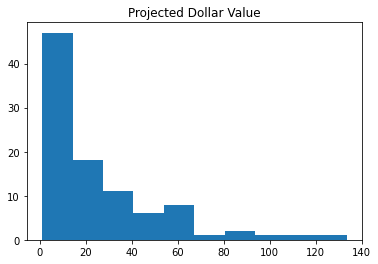

In [6]:
plt.hist(np.hstack(d3['value']))
plt.title('Projected Dollar Value')
plt.show()

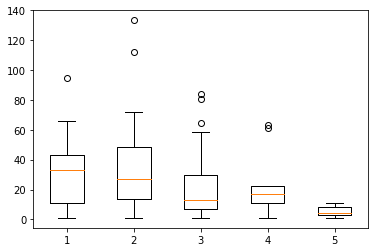

In [7]:
fig1, ax1 = plt.subplots()
data = [d3.loc[d3['pos'] == 'qb','value'], d3.loc[d3['pos'] == 'rb','value'], d3.loc[d3['pos'] == 'wr','value'], d3.loc[d3['pos'] == 'te','value'], d3.loc[d3['pos'] == 'k','value']]
ax1.boxplot(data)
plt.show()

In [8]:
# select rows by index
d3.iloc[range(0,3)]

,PlayerName,pos,points,marg,value
0,Jonathan Taylor,rb,273.580,120.590,133.456404
1,Derrick Henry,rb,254.235,101.245,112.207800
2,Josh Allen,qb,387.502,85.444,94.851936


In [9]:
# select rows by name
d3.loc[[10,20,40,80]]

,PlayerName,pos,points,marg,value
10,Joe Mixon,rb,208.565,55.575,62.043740
20,Mike Evans,wr,116.685,35.830,40.355775
40,George Kittle,te,74.940,17.765,20.513127
80,Tyler Bass,k,153.600,2.800,4.075528


In [10]:
# select columns by index, and first 10 rows
d3.iloc[range(10),[0,4]]

,PlayerName,value
0,Jonathan Taylor,133.456404
1,Derrick Henry,112.207800
2,Josh Allen,94.851936
3,Cooper Kupp,83.731705
4,Deebo Samuel,80.969222
5,Austin Ekeler,71.748130
6,Patrick Mahomes II,66.194605
7,Ja'Marr Chase,64.718351
8,Christian McCaffrey,64.575559
9,Travis Kelce,63.158619


In [11]:
# select columns by name, and 5 random rows
d3.iloc[sample(range(len(d3)), 5), [d3.columns.get_loc(i) for i in ['pos','value']]]

,pos,value
70,wr,7.859526
86,k,2.647604
41,wr,19.442184
60,wr,10.632993
33,rb,23.742432


In [12]:
# be careful when selecting a single column
# no longer a DataFrame
d3.iloc[range(5), d3.columns.get_loc('PlayerName')]

0    Jonathan Taylor
1      Derrick Henry
2         Josh Allen
3        Cooper Kupp
4       Deebo Samuel
Name: PlayerName, dtype: object

In [13]:
# maintain structure
pd.DataFrame(d3.iloc[range(5), d3.columns.get_loc('PlayerName')])

,PlayerName
0,Jonathan Taylor
1,Derrick Henry
2,Josh Allen
3,Cooper Kupp
4,Deebo Samuel


In [14]:
# select rows that satisfy condition
# every 10th row
d3.loc[[(i + 1) % 10 == 0 for i in range(len(d3))]]

,PlayerName,pos,points,marg,value
9,Travis Kelce,te,113.765,56.590,63.158619
19,Kyler Murray,qb,338.784,36.726,41.339944
29,Tee Higgins,wr,105.640,24.785,28.223915
39,Darren Waller,te,76.150,18.975,21.842195
49,DK Metcalf,wr,92.680,11.825,13.988614
59,Elijah Mitchell,rb,161.820,8.830,10.698897
69,Michael Thomas,wr,87.675,6.820,8.491108
79,Ryan Succop,k,154.000,3.200,4.514889
89,Mason Crosby,k,151.200,0.400,1.439361


In [15]:
# quarterbacks
d3.loc[d3['pos'] == 'qb']

,PlayerName,pos,points,marg,value
2,Josh Allen,qb,387.502,85.444,94.851936
6,Patrick Mahomes II,qb,361.412,59.354,66.194605
15,Justin Herbert,qb,342.706,40.648,45.647880
18,Lamar Jackson,qb,339.334,37.276,41.944066
19,Kyler Murray,qb,338.784,36.726,41.339944
21,Jalen Hurts,qb,336.716,34.658,39.068447
31,Tom Brady,qb,325.542,23.484,26.794893
32,Dak Prescott,qb,325.146,23.088,26.359926
58,Joe Burrow,qb,311.088,9.030,10.918578
62,Aaron Rodgers,qb,310.732,8.674,10.527547


In [16]:
# wide receivers or tight ends, but only first 10
d3.loc[[i in ['wr','te'] for i in d3['pos']]].iloc[range(10)]

,PlayerName,pos,points,marg,value
3,Cooper Kupp,wr,156.175,75.320,83.731705
4,Deebo Samuel,wr,153.660,72.805,80.969222
7,Ja'Marr Chase,wr,138.865,58.010,64.718351
9,Travis Kelce,te,113.765,56.590,63.158619
11,Mark Andrews,te,112.150,54.975,61.384698
12,Justin Jefferson,wr,133.340,52.485,58.649675
16,Davante Adams,wr,120.310,39.455,44.337486
20,Mike Evans,wr,116.685,35.830,40.355775
22,Stefon Diggs,wr,115.445,34.590,38.993756
24,Tyreek Hill,wr,112.480,31.625,35.736991


In [17]:
# same thing, different way
d3.loc[[re.match(r'wr|te', i) is not None for i in d3['pos']]].iloc[range(10)]

,PlayerName,pos,points,marg,value
3,Cooper Kupp,wr,156.175,75.320,83.731705
4,Deebo Samuel,wr,153.660,72.805,80.969222
7,Ja'Marr Chase,wr,138.865,58.010,64.718351
9,Travis Kelce,te,113.765,56.590,63.158619
11,Mark Andrews,te,112.150,54.975,61.384698
12,Justin Jefferson,wr,133.340,52.485,58.649675
16,Davante Adams,wr,120.310,39.455,44.337486
20,Mike Evans,wr,116.685,35.830,40.355775
22,Stefon Diggs,wr,115.445,34.590,38.993756
24,Tyreek Hill,wr,112.480,31.625,35.736991


In [18]:
# values greater than 45
d3.loc[d3['value'] > 45]

,PlayerName,pos,points,marg,value
0,Jonathan Taylor,rb,273.580,120.590,133.456404
1,Derrick Henry,rb,254.235,101.245,112.207800
2,Josh Allen,qb,387.502,85.444,94.851936
3,Cooper Kupp,wr,156.175,75.320,83.731705
4,Deebo Samuel,wr,153.660,72.805,80.969222
5,Austin Ekeler,rb,217.400,64.410,71.748130
6,Patrick Mahomes II,qb,361.412,59.354,66.194605
7,Ja'Marr Chase,wr,138.865,58.010,64.718351
8,Christian McCaffrey,rb,210.870,57.880,64.575559
9,Travis Kelce,te,113.765,56.590,63.158619


In [19]:
# combining conditions with AND
# running backs with value between 10 and 15
d3.loc[(d3['pos'] == 'rb') & (d3['value'] >= 20) & (d3['value'] <= 25)]

,PlayerName,pos,points,marg,value
33,Saquon Barkley,rb,173.695,20.705,23.742432
35,Aaron Jones,rb,173.330,20.340,23.341515


In [20]:
# combining conditions with OR
# rounded value ends in '9' or value is 1
d3.loc[(round(d3['value']) % 10 == 9) | (d3['value'] == 1)]

,PlayerName,pos,points,marg,value
12,Justin Jefferson,wr,133.340,52.485,58.649675
21,Jalen Hurts,qb,336.716,34.658,39.068447
22,Stefon Diggs,wr,115.445,34.590,38.993756
41,Michael Pittman Jr.,wr,97.645,16.790,19.442184
66,Matt Gay,k,158.100,7.300,9.018341
67,T.J. Hockenson,te,64.465,7.290,9.007357
68,Adam Thielen,wr,87.845,6.990,8.677836
91,Allen Robinson II,wr,80.855,0.000,1.000000
92,Rodrigo Blankenship,k,150.800,0.000,1.000000
93,Miles Sanders,rb,152.990,0.000,1.000000


In [21]:
# combining conditions with complicated combinations
# kickers with value > 6 or tight end with value < 5
d3.loc[((d3['pos'] == 'k') & (d3['value'] > 6)) | ((d3['pos'] == 'te') & (d3['value'] < 5))]

,PlayerName,pos,points,marg,value
57,Daniel Carlson,k,159.900,9.1,10.995466
61,Justin Tucker,k,159.500,8.7,10.556105
66,Matt Gay,k,158.100,7.3,9.018341
71,Harrison Butker,k,157.000,6.2,7.810098
73,Greg Joseph,k,156.100,5.3,6.821535
95,Tyler Higbee,te,57.175,0.0,1.000000


In [22]:
# select columns that match pattern
m.filter(regex = ("p_.*")).iloc[range(10)]

p_fg  p_xpt  p_pass_yds  p_pass_tds  p_pass_ints  p_rush_yds  \
qb 0   0.0    0.0     176.272       138.4        -27.8       66.23   
   1   0.0    0.0     193.812       143.6        -23.2       36.00   
   2   0.0    0.0     187.336       135.6        -26.6       29.97   
   3   0.0    0.0     149.244        98.4        -26.4       95.69   
   4   0.0    0.0     170.524       109.2        -24.6       55.26   
   5   0.0    0.0     145.836        97.6        -25.6       77.28   
   6   0.0    0.0     193.752       145.6        -23.8        4.59   
   7   0.0    0.0     182.836       133.6        -23.4       22.91   
   8   0.0    0.0     183.148       125.2        -25.6       18.74   
   9   0.0    0.0     173.312       130.4        -14.2       13.62   

      p_rush_tds  p_fumbles  p_rec_yds  p_rec_tds  
qb 0        41.4       -7.0        0.0        0.0  
   1        16.8       -5.6        0.0        0.0  
   2        19.2       -2.8        0.0        0.0  
   3        29.4       -7.0        0.0        0.0  
   4        33.0       -4.6        0.0        0.0  
   5        47.4       -5.8        0.0        0.0  
   6        10.2       -4.8        0.0        0.0  
   7        17.4       -8.2        0.0        0.0  
   8        13.2       -3.6        0.0        0.0  
   9        10.8       -3.2        0.0        0.0

In [23]:
# select empty DataFrame
d3.loc[[False] * len(d3)]

,PlayerName,pos,points,marg,value


<!--
quarto render ffv_py.qmd
-->